In [15]:
import sys
from pathlib import Path
import os


current_dir = Path().absolute()
if current_dir.name == 'skelvit':
    project_root = current_dir
else:
    project_root = current_dir.parent / 'skelvit'

sys.path.insert(0, str(project_root))
print(f"Project root: {project_root}")
print(f"Python path updated")

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import trimesh
from typing import Optional

from huggingface_hub import hf_hub_download


from models.skelvit import SKELViT
from vis.skelvit_render import SKELViTRender
from vis.mesh_estimator import HumanMeshEstimator, resize_image, fix_prefix_state_dict
from vis.dataset import Dataset
from vis.renderer_vis import Renderer
from util.data import recursive_to
from body_models.skel_wrapper import SKELWrapper
from util.utils_detectron2 import DefaultPredictor_Lazy
from util.constants import CAM_MODEL_CKPT, DETECTRON_CKPT, IMAGE_MEAN, IMAGE_STD
from datasets.constants import DETECTRON_CFG
from detectron2.config import LazyConfig
from torchvision.transforms import Normalize

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


Project root: /mnt/data1/SKEL_project/skelvit
Python path updated
PyTorch version: 2.0.0+cu117
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3090


In [ ]:
def download_model_from_hf(
    repo_id: str,
    filename: str = "best.pth",
    cache_dir: Optional[str] = None,
    force_download: bool = False,
) -> str:

    if cache_dir is None:
        # Use default HF cache directory
        cache_dir = os.path.join(os.path.expanduser("~"), ".cache", "huggingface", "hub")
    else:
        # Expand user path if it contains ~
        cache_dir = os.path.expanduser(cache_dir)

    direct_path = os.path.join(cache_dir, filename)
    if os.path.exists(direct_path) and not force_download:
        print(f"✓ Found existing file at: {direct_path} (skipping download)")
        return direct_path

    repo_name = repo_id.replace("/", "--")
    hf_cache_pattern = os.path.join(cache_dir, f"models--{repo_name}")
    
    if os.path.exists(hf_cache_pattern):
        snapshots_dir = os.path.join(hf_cache_pattern, "snapshots")
        if os.path.exists(snapshots_dir):
            for item in os.listdir(snapshots_dir):
                snapshot_path = os.path.join(snapshots_dir, item, filename)
                if os.path.exists(snapshot_path) and not force_download:
                    print(f"✓ Found existing file in HF cache: {snapshot_path} (skipping download)")
                    return snapshot_path

    print(f"File not found in cache, downloading from Hugging Face...")
    local_path = hf_hub_download(
        repo_id=repo_id,
        filename=filename,
        cache_dir=cache_dir,
        force_download=force_download,
    )
    return local_path


def get_hf_checkpoint_path(
    repo_id: str,
    filename: str = "best.pth",
    cache_dir: Optional[str] = None,
) -> str:

    return download_model_from_hf(repo_id, filename, cache_dir, force_download=False)


print("✓ Hugging Face helper functions defined")


✓ Hugging Face helper functions defined


In [ ]:
# Hugging Face repository information
HF_REPO_ID = "Intellindust/SKEL_CF_vitpose_H"
HF_FILENAME = "best.pth"

CUSTOM_CACHE_DIR = str("~/.cache/huggingface/hub/")  

# Download checkpoint from Hugging Face
print(f"Downloading model from {HF_REPO_ID}/{HF_FILENAME}...")
checkpoint_path = get_hf_checkpoint_path(HF_REPO_ID, HF_FILENAME, cache_dir=CUSTOM_CACHE_DIR)
print(f"✓ Model downloaded to: {checkpoint_path}")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
map_location = device 

print(f"Loading checkpoint to {map_location}...")
checkpoint = torch.load(checkpoint_path, map_location=map_location, weights_only=False)
print(f"✓ Checkpoint loaded to {map_location}. Keys: {list(checkpoint.keys())}")


✓ Found existing file at: /home/jjp/.cache/huggingface/hub/best.pth (skipping download)
✓ Model downloaded to: /home/jjp/.cache/huggingface/hub/best.pth
Loading checkpoint to cuda:0...
✓ Checkpoint loaded to cuda:0. Keys: ['model', 'ema_model', 'optimizer', 'lr_scheduler', 'epoch', 'cfg']


In [ ]:
from omegaconf import OmegaConf
from hydra import compose, initialize_config_dir
from pathlib import Path

config_dir = str(project_root / "config")
config_name = "vis.yaml"

with initialize_config_dir(config_dir=config_dir, version_base="1.2"):
    cfg = compose(config_name=config_name)

cfg.trainer.ckpt_path = checkpoint_path
cfg.hub.skel_head.transformer_decoder.context_dim = 1280
cfg.trainer.backbone = "vitpose_h"
cfg.misc.num_keep = 1 

print(f"✓ Configuration loaded")
print(f"  - Checkpoint path: {cfg.trainer.ckpt_path}")
print(f"  - Context dim: {cfg.hub.skel_head.transformer_decoder.context_dim}")
print(f"  - Backbone: {cfg.trainer.backbone}")

print("\nInitializing model...")
estimator = HumanMeshEstimator(cfg=cfg)
print("✓ Model initialized")


✓ Configuration loaded
  - Checkpoint path: /home/jjp/.cache/huggingface/hub/best.pth
  - Context dim: 1280
  - Backbone: vitpose_h

Initializing model...
✓ Model initialized


Processing image: /mnt/data1/SKEL_project/skelvit/data_inputs/demo/000000000785.jpg


/mnt/data1/miniconda3/envs/skelvit/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


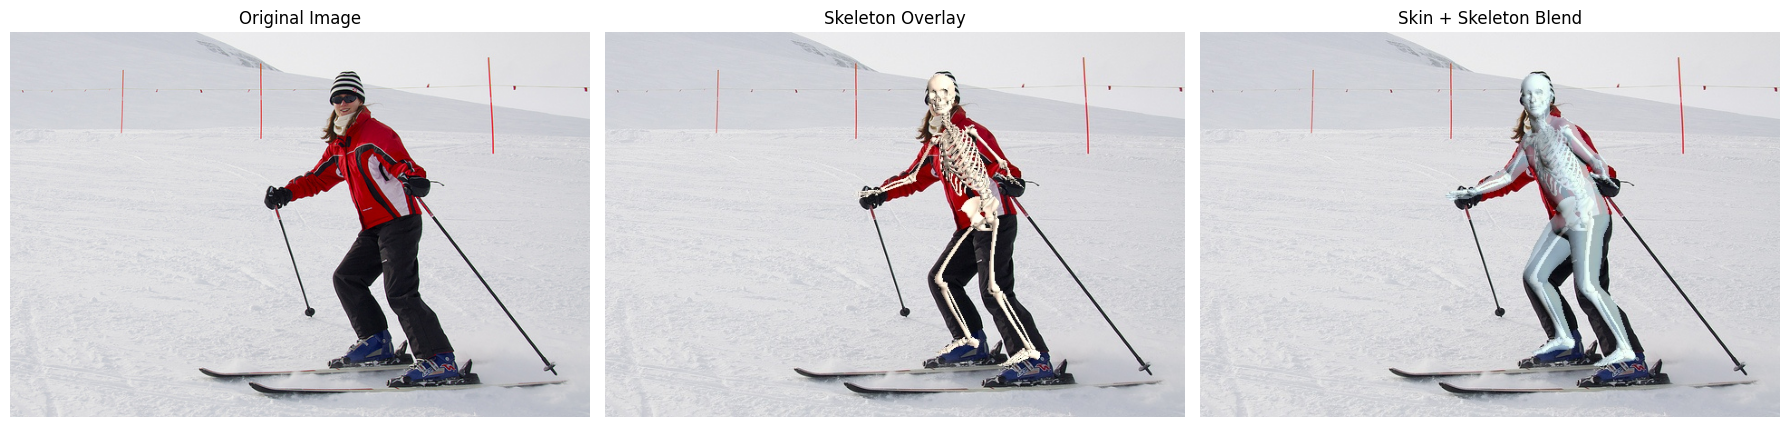

✓ Processing complete. Results saved to: /tmp/skelvit_demo_output


In [ ]:
image_path = str("/mnt/data1/SKEL_project/skelvit/data_inputs/demo/000000000785.jpg")

img_cv2 = cv2.imread(image_path)
if img_cv2 is None:
    print(f"Error: Could not load image from {image_path}")
    print("Please set image_path to a valid image file path")
else:
    print(f"Processing image: {image_path}")

    temp_output_dir = "/tmp/skelvit_demo_output"
    os.makedirs(temp_output_dir, exist_ok=True)

    estimator.process_image(image_path, temp_output_dir)

    fname = os.path.splitext(os.path.basename(image_path))[0]
    img_ext = os.path.splitext(os.path.basename(image_path))[1] if os.path.splitext(os.path.basename(image_path))[1] else ".jpg"

    concat_img_path = os.path.join(temp_output_dir, f"{fname}_concat{img_ext}")
    mixed_img_path = os.path.join(temp_output_dir, f"{fname}_mixed{img_ext}")
    skel_img_path = os.path.join(temp_output_dir, f"{fname}_skel{img_ext}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image", fontsize=12)
    axes[0].axis('off')

    if os.path.exists(skel_img_path):
        skel_img = cv2.imread(skel_img_path)
        axes[1].imshow(cv2.cvtColor(skel_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Skeleton Overlay", fontsize=12)
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, "Skeleton image not found", ha='center', va='center')
        axes[1].axis('off')

    if os.path.exists(mixed_img_path):
        mixed_img = cv2.imread(mixed_img_path)
        axes[2].imshow(cv2.cvtColor(mixed_img, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Skin + Skeleton Blend", fontsize=12)
        axes[2].axis('off')
    elif os.path.exists(concat_img_path):
        concat_img = cv2.imread(concat_img_path)
        axes[2].imshow(cv2.cvtColor(concat_img, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Full Result (concat)", fontsize=12)
        axes[2].axis('off')
    else:
        axes[2].text(0.5, 0.5, "Result image not found", ha='center', va='center')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Processing complete. Results saved to: {temp_output_dir}")
